In [1]:
import os
import sys
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


from keras.callbacks import *
from imblearn.over_sampling import RandomOverSampler 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import warnings
warnings.filterwarnings('ignore')

metadata = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
hmnist_8_8_RGB = "/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv"
hmnist_28_28_RGB = "/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv"
hmnist_8_8_L = "/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv"
hmnist_28_28_L = "/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv"


classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [2]:
df = pd.read_csv(hmnist_28_28_RGB, delimiter=',')
df.dataframeName = 'hmnist_28_28_RGB.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 10015 rows and 2353 columns


In [3]:
df.head()

label = df["label"]
data = df.drop(columns=["label"]) 
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,192,153,193,195,155,192,197,154,185,202,...,134,173,124,138,183,147,166,185,154,177
1,25,14,30,68,48,75,123,93,126,158,...,82,60,39,55,25,14,28,25,14,27
2,192,138,153,200,145,163,201,142,160,206,...,149,167,129,143,159,124,142,136,104,117
3,38,19,30,95,59,72,143,103,119,171,...,73,44,26,36,25,12,17,25,12,15
4,158,113,139,194,144,174,215,162,191,225,...,201,209,166,185,172,135,149,109,78,92


In [4]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    columnNames = list(df)
    if len(columnNames) > 10:
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

<AxesSubplot:xlabel='label', ylabel='count'>

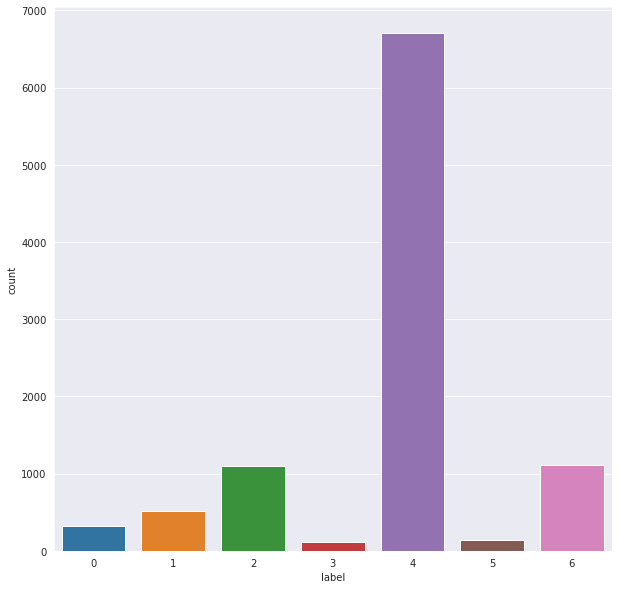

In [5]:
# plotting the labeled data 
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(label)

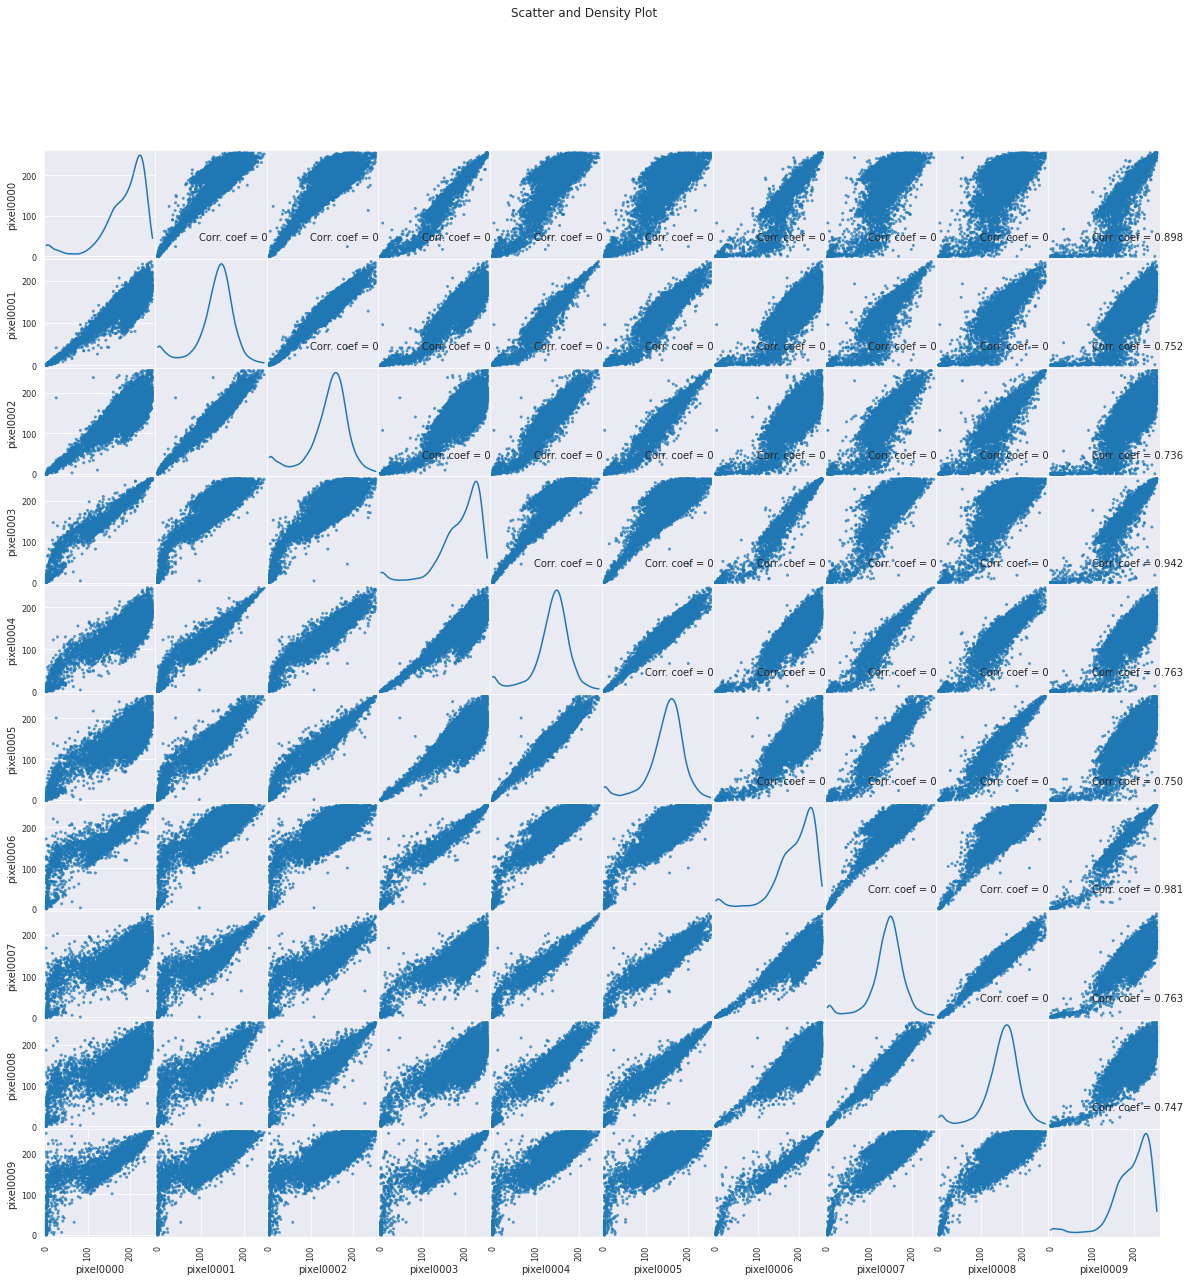

In [6]:
plotScatterMatrix(df, 20, 10)

In [7]:
# our dataset is immbalanced, so we try to balanced the data using oversample the data usinfg random points
oversample = RandomOverSampler()
data,label  = oversample.fit_resample(data,label)
data = np.array(data).reshape(-1,28,28,3)
label = np.array(label)
print(type(label))
data.shape

<class 'numpy.ndarray'>


(46935, 28, 28, 3)

<AxesSubplot:ylabel='count'>

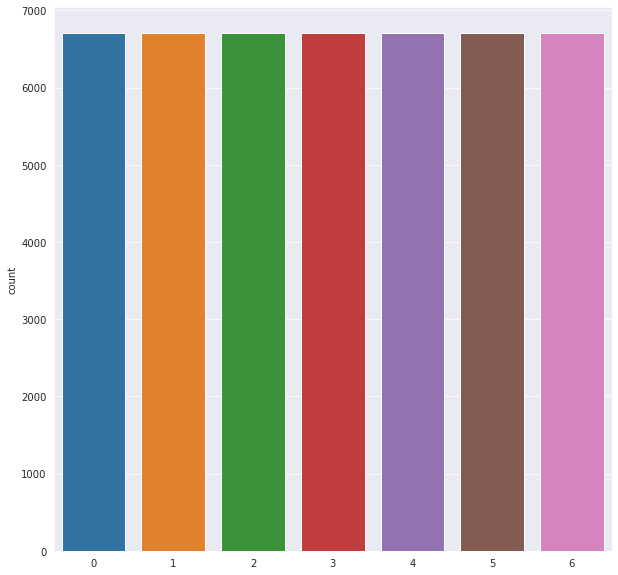

In [8]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(label)

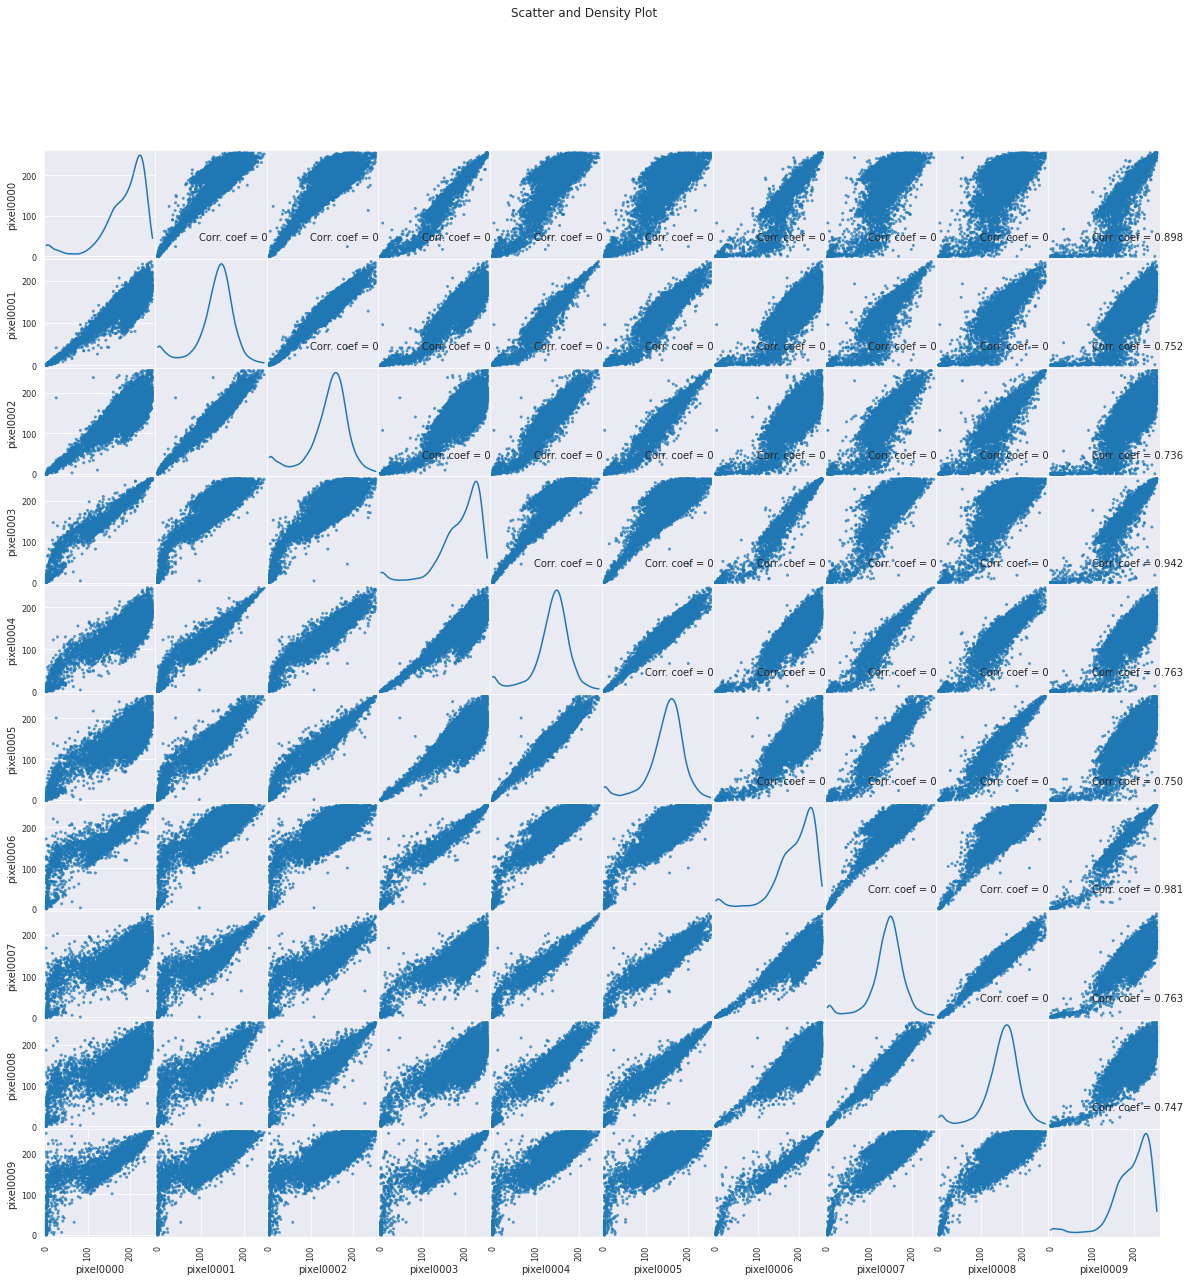

In [9]:
plotScatterMatrix(df, 20, 10)

In [10]:
X_train , X_test , y_train , y_test = train_test_split(data , label , test_size = 0.2 , random_state = 42)

In [11]:
def plotImg(img):
    plt.imshow(img)
    plt.title("Skin Cancer Image")
    plt.grid(False)
    plt.axis("off")
    plt.show()

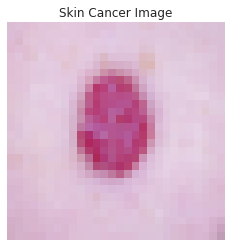

In [12]:
plotImg(X_train[0])

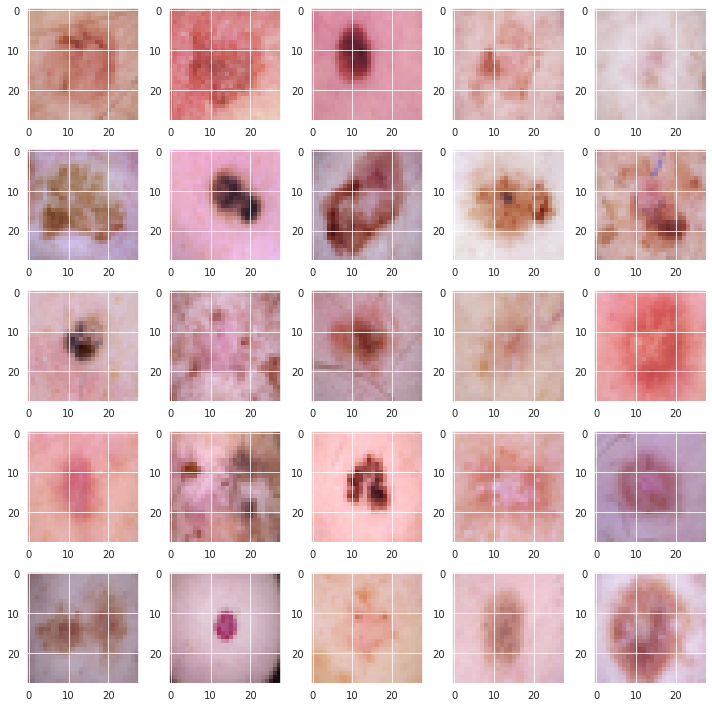

In [13]:
fig, axes = plt.subplots(5,5)
fig.set_size_inches(10, 10)
for i in range(5):
    for j in range(5):
        n = np.random.randint(0,1000, 1)
        axes[i,j].imshow(X_train[n].reshape(28,28,3))
    plt.tight_layout()

In [14]:
#one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
# #Data Augmentation
# datagen = ImageDataGenerator(rescale=(1./255)
#                              ,rotation_range=10
#                              ,zoom_range = 0.1
#                              ,width_shift_range=0.1
#                              ,height_shift_range=0.1)
# testgen = ImageDataGenerator(rescale=(1./255))

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

In [17]:
#CNN Model
def model1():
    model = Sequential()
    #layer1
    model.add(Rescaling(1./255, input_shape=(28, 28, 3) ))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #layer2
    model.add(Conv2D(32, (3, 3) , padding='same'))
    model.add(Activation('relu'))
    #layer3
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #layer4
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    #classfier
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    return model
    
    
def model2():
    model = Sequential()
    #layer1
    model.add(Rescaling(1./255, input_shape=(28, 28, 3) ))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #layer2
    model.add(Conv2D(32, (3, 3) , padding='same'))
    model.add(Activation('relu'))
    #layer3
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #layer4
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    #classifier
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    return model
    
def model3():
    model = Sequential()
    #layer1
    model.add(Rescaling(1./255, input_shape=(28, 28, 3) ))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #layer2
    model.add(Conv2D(32, (3, 3) , padding='same'))
    model.add(Activation('relu'))
    #layer3
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #layer4
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # classifier
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    return model
    
    
def model4():
    input_ = Input(shape = [28,28,3])
    layer1 = Conv2D(32 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(input_)
    pool1 = MaxPooling2D()(layer1)
    normal1 = BatchNormalization()(pool1)
    layer2 = Conv2D(64 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(normal1)
    layer3 = Conv2D(64 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(layer2)
    pool2 = MaxPooling2D()(layer3)
    normal2 = BatchNormalization()(pool2)
    layer4 = Conv2D(128 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(normal2)
    layer5 = Conv2D(128 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(layer4)
    pool3 = MaxPooling2D()(layer5)
    normal3 = BatchNormalization()(pool3)
    layer6 = Conv2D(256 , (3,3) , activation='relu' ,padding='same', kernel_initializer='he_normal')(normal3)
    layer7 = Conv2D(256 , (3,3) , activation='relu' ,padding='same', kernel_initializer='he_normal')(layer6)
    pool4 = MaxPooling2D()(layer7)


    flatten  = Flatten()(pool4)
    dropout1 = Dropout(rate = 0.2)(flatten)
    dense1 = Dense(units = 256 , activation = 'relu' , kernel_initializer = 'he_normal')(dropout1)
    normal4 = BatchNormalization()(dense1)
    dense2 = Dense(units = 128 , activation = 'relu' , kernel_initializer = 'he_normal')(normal4)
    normal5 = BatchNormalization()(dense2)
    dense3 = Dense(units = 64 , activation = 'relu' , kernel_initializer = 'he_normal')(normal5)
    normal6 = BatchNormalization()(dense3) 
    dense4 = Dense(units = 32 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_regularizer=keras.regularizers.L1L2())(normal6)
    normal7 = BatchNormalization()(dense4) 
    dense5 = Dense(units = 7 , activation='softmax' ,kernel_initializer="glorot_uniform" , name = 'classifier')(normal7)

    return Model(inputs = input_ ,outputs = dense5)

In [18]:
model_1 = model1()
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0

In [19]:
model_2 = model2()
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 64)       

In [20]:
model_3 = model3()
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_14 (Activation)   (None, 28, 28, 64)       

In [21]:
model_4 = model4()
model_4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0     

In [22]:
#plotting model
# keras.utils.plot_model(model)

In [23]:
model_1.compile(optimizer='adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])
model_2.compile(optimizer='adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])
model_3.compile(optimizer='adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])
model_4.compile(optimizer='adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

In [24]:
#Training
print("Training Model 1 Started...")
history1 = model_1.fit(X_train ,y_train ,epochs=20 ,batch_size=128,validation_data=(X_test , y_test) ,callbacks=[learning_rate_reduction, early_stopping])
print("Training Model 1 Completed...")
print("Training Model 2 Started...")
history2 = model_2.fit(X_train ,y_train ,epochs=20 ,batch_size=128,validation_data=(X_test , y_test) ,callbacks=[learning_rate_reduction, early_stopping])
print("Training Model 2 Completed...")
print("Training Model 3 Started...")
history3 = model_3.fit(X_train ,y_train ,epochs=20 ,batch_size=128,validation_data=(X_test , y_test) ,callbacks=[learning_rate_reduction, early_stopping])
print("Training Model 3 Completed...")
print("Training Model 4 Started...")
history4 = model_4.fit(X_train ,y_train ,epochs=20 ,batch_size=128,validation_data=(X_test , y_test) ,callbacks=[learning_rate_reduction, early_stopping])
print("Training Model 4 Completed...")

Training Model 1 Started...
Epoch 1/20
294/294 [==============================] - 11s 13ms/step - loss: 1.2017 - accuracy: 0.5316 - val_loss: 0.7191 - val_accuracy: 0.7455
Epoch 2/20
294/294 [==============================] - 3s 11ms/step - loss: 0.5375 - accuracy: 0.8058 - val_loss: 0.3728 - val_accuracy: 0.8663
Epoch 3/20
294/294 [==============================] - 3s 11ms/step - loss: 0.2909 - accuracy: 0.8973 - val_loss: 0.2880 - val_accuracy: 0.9015
Epoch 4/20
294/294 [==============================] - 3s 11ms/step - loss: 0.1859 - accuracy: 0.9345 - val_loss: 0.1782 - val_accuracy: 0.9398
Epoch 5/20
294/294 [==============================] - 3s 11ms/step - loss: 0.1351 - accuracy: 0.9525 - val_loss: 0.2126 - val_accuracy: 0.9302
Epoch 6/20
294/294 [==============================] - 3s 11ms/step - loss: 0.1086 - accuracy: 0.9606 - val_loss: 0.1339 - val_accuracy: 0.9609
Epoch 7/20
294/294 [==============================] - 3s 11ms/step - loss: 0.0925 - accuracy: 0.9668 - val_loss: 

In [25]:
#testing
model_1.evaluate(X_test , y_test)
model_2.evaluate(X_test , y_test)
model_3.evaluate(X_test , y_test)
model_4.evaluate(X_test , y_test)

294/294 [==============================] - 1s 4ms/step - loss: 0.2364 - accuracy: 0.9438


[0.23640485107898712, 0.9437519907951355]

In [26]:
#predicting
y_pred1  = model1.predict(X_test).round()
y_pred2  = model2.predict(X_test).round()
y_pred3  = model3.predict(X_test).round()
y_pred4  = model4.predict(X_test).round()



AttributeError: 'function' object has no attribute 'predict'

In [ ]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred1 , target_names =target_names ))

In [ ]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred2 , target_names =target_names ))

In [ ]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred3 , target_names =target_names ))

In [ ]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred4 , target_names =target_names ))

In [27]:
#training acc vs testing acc graph
def plot(history, model_name, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'ro-',label='Training Accuracy', )
    plt.plot(epochs_range, val_acc, 'go-', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy {model_name}')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'ro-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'go-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss {model_name}')
    plt.show()

In [ ]:
plot(history1, 'model 1', epochs = len(history1.history['loss']))

In [ ]:
plot(history2, 'model 2', epochs = len(history2.history['loss']))

In [ ]:
plot(history3, 'model 3', epochs = len(history3.history['loss']))

In [ ]:
plot(history4, 'model 4', epochs = len(history4.history['loss']))

****Saving all the models

In [28]:
model_1.save("/kaggle/working/model1.h5")
model_2.save("/kaggle/working/model2.h5")
model_3.save("/kaggle/working/model3.h5")
model_4.save("/kaggle/working/model4.h5")

In [29]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the individual models
model1 = load_model('model1.h5')
model2 = load_model('model2.h5')
model3 = load_model('model3.h5')
model4 = load_model('model4.h5')

# Making model names unique
model1._name = 'model1'
model2._name = 'model2'
model3._name = 'model3'
model4._name = 'model4'

# Create a new input layer that matches the input shape of the individual models
ensemble_input = tf.keras.Input(shape=model1.input_shape[1:])

# Get the outputs of each model
output1 = model1(ensemble_input)
output2 = model2(ensemble_input)
output3 = model3(ensemble_input)
output4 = model4(ensemble_input)

# Average the outputs
ensemble_output = tf.keras.layers.Average()([output1, output2, output3, output4])

# Create the ensemble model
ensemble_model = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output)

In [30]:
# we will retrain our final model for some epochs to get better accuracy
model5 = ensemble_model
model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
model1 (Sequential)             (None, 7)            1672231     input_2[0][0]                    
__________________________________________________________________________________________________
model2 (Sequential)             (None, 7)            1672231     input_2[0][0]                    
__________________________________________________________________________________________________
model3 (Sequential)             (None, 7)            1706151     input_2[0][0]                    
____________________________________________________________________________________________

In [31]:
model5.compile(optimizer='adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])
print("Training Model 5 Started...")
history = model5.fit(X_train ,y_train ,epochs=7 ,batch_size=128,validation_data=(X_test , y_test) ,callbacks=[learning_rate_reduction, early_stopping])
print("Training Model 5 Completed...")

Training Model 5 Started...
Epoch 1/7
294/294 [==============================] - 13s 37ms/step - loss: 0.0217 - accuracy: 0.9993 - val_loss: 0.0884 - val_accuracy: 0.9798
Epoch 2/7
294/294 [==============================] - 10s 35ms/step - loss: 0.0304 - accuracy: 0.9987 - val_loss: 0.0858 - val_accuracy: 0.9831
Epoch 3/7
294/294 [==============================] - 10s 35ms/step - loss: 0.0345 - accuracy: 0.9985 - val_loss: 0.1173 - val_accuracy: 0.9802
Epoch 4/7
294/294 [==============================] - 10s 35ms/step - loss: 0.0298 - accuracy: 0.9985 - val_loss: 0.1039 - val_accuracy: 0.9813
Epoch 5/7
294/294 [==============================] - 10s 35ms/step - loss: 0.0337 - accuracy: 0.9982 - val_loss: 0.1123 - val_accuracy: 0.9814
Epoch 6/7
294/294 [==============================] - 10s 35ms/step - loss: 0.0350 - accuracy: 0.9982 - val_loss: 0.1858 - val_accuracy: 0.9737
Epoch 7/7
294/294 [==============================] - 10s 35ms/step - loss: 0.0364 - accuracy: 0.9980 - val_loss: 0

In [32]:
model5.evaluate(X_test , y_test)
#predicting
y_pred  = model5.predict(X_test).round()

# Save the model
model5.save('/kaggle/working/model5.h5')

294/294 [==============================] - 2s 5ms/step - loss: 0.1385 - accuracy: 0.9810


In [33]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred , target_names =target_names ))


                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       1.00      1.00      1.00      1295
                             ('bcc', ' basal cell carcinoma')       0.99      1.00      0.99      1323
                     ('bkl', 'benign keratosis-like lesions')       0.99      0.98      0.98      1351
                                     ('df', 'dermatofibroma')       1.00      1.00      1.00      1392
                                  ('nv', ' melanocytic nevi')       0.99      0.86      0.92      1346
              ('vasc', ' pyogenic granulomas and hemorrhage')       1.00      1.00      1.00      1292
                                          ('mel', 'melanoma')       0.96      0.99      0.98      1388

                                                    micro avg       0.99      0.98      0.98      9387
                                                    macro avg       0.9

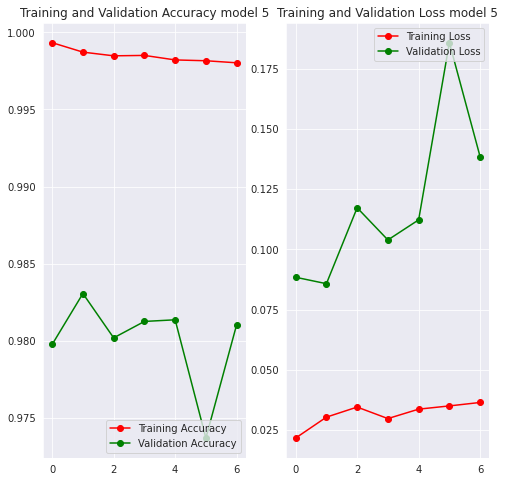

In [34]:
plot(history, 'model 5', epochs = len(history.history['loss']))

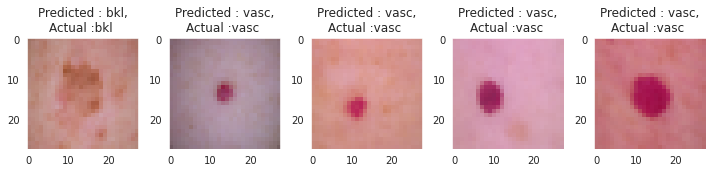

In [35]:
#visualizing prediction
correct = np.nonzero(y_pred == y_test)[1]
fig, axes = plt.subplots(1,5)
fig.set_size_inches(10, 10)
k = 0 
for c in correct[:5]:
    plt.subplot(2,5,k+1)
    plt.imshow(X_test[k].reshape(28,28,3) , interpolation='none')
    plt.title(f"Predicted : {classes[y_pred[k].argmax(axis = 0)][0]},\nActual :{classes[y_test[k].argmax(axis = 0)][0]} ")
    plt.tight_layout()
    plt.grid(False)
    k += 1

In [38]:
from keras.preprocessing import image
import numpy as np
import keras

# Load and prepare the image
m = keras.models.load_model("/kaggle/working/model5.h5")
img_path_1 = '/kaggle/input/google-images/Basal.png' 
img_path_2 = '/kaggle/input/google-images/Melanocytic.png'
img1 = image.load_img(img_path_1, target_size=(28, 28))
img2 = image.load_img(img_path_2, target_size=(28, 28))
img_array_1 = image.img_to_array(img1)
img_array_1 = np.expand_dims(img_array_1, axis=0) 

img_array_2 = image.img_to_array(img2)
img_array_2 = np.expand_dims(img_array_2, axis=0) 

# Predict the cancer type
prediction_1 = m.predict(img_array_1)
prediction_2 = m.predict(img_array_2)
print(prediction_1, prediction_2)

[[5.15998124e-07 7.47288167e-01 7.37135952e-09 1.05601076e-10
  2.52710819e-01 1.21946855e-10 5.06863898e-07]] [[6.8537773e-08 4.4161337e-03 2.0240514e-09 8.3526197e-10 9.9558294e-01
  4.9886839e-12 8.7718183e-07]]


In [39]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

max1 = 0
max2 = 0
x = 0
y = 0

for i in range(7):
    if (prediction_1[0][i] > max1).any():
        max1 = prediction_1[0][i]
        x = i
    if (prediction_2[0][i] > max2).any():
        max2 = prediction_2[0][i]
        y = i

print("Image 1: ", classes[x],"Image 2:", classes[y])

Image 1:  ('bcc', ' basal cell carcinoma') Image 2: ('nv', ' melanocytic nevi')
